In [1]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import optuna
import torch.optim as optim

In [10]:
df = pd.read_csv("../../data/preprocessed/temp/LENDAVA.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head(30))

   Location                Date  Temperature  Temperature dew point  \
0   Lendava 2025-04-01 12:30:00         10.0                    4.1   
1   Lendava 2025-04-01 13:00:00         11.1                    4.8   
2   Lendava 2025-04-01 13:30:00         10.9                    4.2   
3   Lendava 2025-04-01 14:00:00         11.6                    4.5   
4   Lendava 2025-04-01 14:30:00         11.9                    4.1   
5   Lendava 2025-04-01 15:00:00         12.9                    5.1   
6   Lendava 2025-04-01 15:30:00         12.3                    4.5   
7   Lendava 2025-04-01 16:00:00         11.9                    4.2   
8   Lendava 2025-04-01 16:30:00         11.4                    4.4   
9   Lendava 2025-04-01 17:00:00         11.7                    4.5   
10  Lendava 2025-04-01 17:30:00         11.6                    4.4   
11  Lendava 2025-04-01 18:00:00         11.5                    4.5   
12  Lendava 2025-04-01 18:30:00         11.3                    4.4   
13  Le

In [11]:
drop_cols = [
    "Location",  # constant
    "Temperature average in time interval",  # correlated with target
    "Temperature maximum in time interval",
    "Temperature minimum in time interval",
    "Humidity relative average in time interval",
    "Wind direction average in time interval",
    "Wind direction maximum gust in time interval",
    "Wind speed average in time interval",
    "Wind speed maximum in time interval",
    "Air pressure average in time interval",
    "Solar radiation average in time interval"
]

df = df.drop(columns=drop_cols)
print(df.head(30))

                  Date  Temperature  Temperature dew point  Humidity relative  \
0  2025-04-01 12:30:00         10.0                    4.1                 67   
1  2025-04-01 13:00:00         11.1                    4.8                 65   
2  2025-04-01 13:30:00         10.9                    4.2                 63   
3  2025-04-01 14:00:00         11.6                    4.5                 62   
4  2025-04-01 14:30:00         11.9                    4.1                 59   
5  2025-04-01 15:00:00         12.9                    5.1                 59   
6  2025-04-01 15:30:00         12.3                    4.5                 59   
7  2025-04-01 16:00:00         11.9                    4.2                 59   
8  2025-04-01 16:30:00         11.4                    4.4                 62   
9  2025-04-01 17:00:00         11.7                    4.5                 61   
10 2025-04-01 17:30:00         11.6                    4.4                 61   
11 2025-04-01 18:00:00      

In [12]:
print(df["Air pressure"].head(10))

0    999.7
1    999.4
2    999.3
3    999.1
4    999.0
5    998.5
6    998.5
7    998.4
8    998.4
9    998.3
Name: Air pressure, dtype: float64


In [13]:
df["hour"] = df["Date"].dt.hour
df["minute"] = df["Date"].dt.minute
df["dayofweek"] = df["Date"].dt.dayofweek + 1   # make Monday 1st day of the week
df["month"] = df["Date"].dt.month

print(df["hour"].tail((10)))
print(df["minute"].tail(10))
print(df["dayofweek"].tail(10))
print(df["month"].tail(10))

2659    23
2660    23
2661     0
2662     0
2663     1
2664     1
2665     2
2666     2
2667     3
2668     3
Name: hour, dtype: int32
2659     0
2660    30
2661     0
2662    30
2663     0
2664    30
2665     0
2666    30
2667     0
2668    30
Name: minute, dtype: int32
2659    1
2660    1
2661    2
2662    2
2663    2
2664    2
2665    2
2666    2
2667    2
2668    2
Name: dayofweek, dtype: int32
2659    5
2660    5
2661    5
2662    5
2663    5
2664    5
2665    5
2666    5
2667    5
2668    5
Name: month, dtype: int32


In [14]:
""" df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["minute_sin"] = np.sin(2 * np.pi * df["minute"] / 60)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["minute_cos"] = np.cos(2 * np.pi * df["minute"] / 60)

print(df["hour_sin"].tail(30))
print(df["hour_cos"].tail(10)) """


df["total_minutes"] = df["hour"] * 60 + df["minute"]
df["time_sin"] = np.sin(2 * np.pi * df["total_minutes"] / 1440)
df["time_cos"] = np.cos(2 * np.pi * df["total_minutes"] / 1440)

print(df["Date"].tail(10))
print(df["time_sin"].tail(10))
print(df["time_cos"].tail(10)) 

2659   2025-05-26 23:00:00
2660   2025-05-26 23:30:00
2661   2025-05-27 00:00:00
2662   2025-05-27 00:30:00
2663   2025-05-27 01:00:00
2664   2025-05-27 01:30:00
2665   2025-05-27 02:00:00
2666   2025-05-27 02:30:00
2667   2025-05-27 03:00:00
2668   2025-05-27 03:30:00
Name: Date, dtype: datetime64[ns]
2659   -0.258819
2660   -0.130526
2661    0.000000
2662    0.130526
2663    0.258819
2664    0.382683
2665    0.500000
2666    0.608761
2667    0.707107
2668    0.793353
Name: time_sin, dtype: float64
2659    0.965926
2660    0.991445
2661    1.000000
2662    0.991445
2663    0.965926
2664    0.923880
2665    0.866025
2666    0.793353
2667    0.707107
2668    0.608761
Name: time_cos, dtype: float64


In [15]:
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

C:\Users\jakob\AppData\Local\Temp\ipykernel_11584\3809542706.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\Users\jakob\AppData\Local\Temp\ipykernel_11584\3809542706.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [16]:
print(df.tail((10)))

                    Date  Temperature  Temperature dew point  \
2659 2025-05-26 23:00:00         14.4                   11.7   
2660 2025-05-26 23:30:00         14.2                   12.0   
2661 2025-05-27 00:00:00         13.4                   11.4   
2662 2025-05-27 00:30:00         12.9                   11.1   
2663 2025-05-27 01:00:00         13.1                   11.5   
2664 2025-05-27 01:30:00         13.2                   11.2   
2665 2025-05-27 02:00:00         12.4                   10.7   
2666 2025-05-27 02:30:00         11.4                    9.8   
2667 2025-05-27 03:00:00         10.9                    9.6   
2668 2025-05-27 03:30:00         10.7                    9.4   

      Humidity relative  Wind direction  Wind speed  Air pressure  \
2659                 84             274           1         999.2   
2660                 86             138           1         999.4   
2661                 88             355           1         999.6   
2662               

In [17]:
temp_scaler = MinMaxScaler()
other_scaler = MinMaxScaler()

# fit temperature scaler
df["Temperature_scaled"] = temp_scaler.fit_transform(df[["Temperature"]])

other_columns = df.columns.drop(["Date", "Temperature"])  # keep everything except Temperature (target) and Date
other_features = df[other_columns]
other_scaled = pd.DataFrame(
    other_scaler.fit_transform(other_features),
    columns=other_columns
)

# combine everything
scaled_df = pd.concat([other_scaled, df[["Temperature_scaled"]].rename(columns={"Temperature_scaled": "Temperature"})], axis=1)

In [18]:
# save scaler for possible use of inverse-transform later on
joblib.dump(temp_scaler, "temp_scaler.pkl")
joblib.dump(other_scaler, "other_scaler.pkl")

['other_scaler.pkl']

In [19]:
lookback = 240
forecast_horizon = 6

""" def create_sequences(data, target_col="Temperature", lookback=12, forecast_horizon=6):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)
    for i in range(len(data) - lookback - forecast_horizon):Đ
        seq_x = data.iloc[i:i + lookback].values
        seq_y = data.iloc[i + lookback + forecast_horizon - 1, target_idx]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y) """

def create_sequences(data, target_col="Temperature", lookback=12, forecast_horizon=6):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)
    for i in range(len(data) - lookback - forecast_horizon):
        seq_x = data.iloc[i:i + lookback].values
        seq_y = data.iloc[i + lookback : i + lookback + forecast_horizon, target_idx]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)  # y shape: (samples, 6)


X, y = create_sequences(scaled_df, target_col="Temperature", lookback=lookback, forecast_horizon=forecast_horizon)

print(f"Shape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of y (samples,): {y.shape}")

Shape of X (samples, timesteps, features): (2423, 240, 16)
Shape of y (samples,): (2423, 6)


In [20]:
# no shuffle - important for time series
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

print(f"rows in df: {len(scaled_df)}")
print(f"all samples: {len(X)}")
print(f"train samples: {len(X_train)}")
print(f"validation samples: {len(X_val)}")
print(f"test samples: {len(X_test)}")

rows in df: 2669
all samples: 2423
train samples: 1550
validation samples: 388
test samples: 485


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# assuming X shape is (samples, timesteps, features)
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
class TemperatureForecaster(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2, forecast_horizon=6):
        super(TemperatureForecaster, self).__init__()
        
        self.forecast_horizon = forecast_horizon

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout)

        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(dropout)

        # Final output layer
        self.output = nn.Linear(16, forecast_horizon)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]

        x = self.fc1(last_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        out = self.output(x)
        return out

In [23]:
class EarlyStopping:
    """
    Args:
        patience (int): How many epochs to wait after last time validation loss improved.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False


In [62]:
input_size = X.shape[2]  # number of features
model = TemperatureForecaster(input_size=input_size, hidden_size=128, num_layers=3, dropout=0.123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0097)

early_stopping = EarlyStopping(patience=7, min_delta=0.001) 


epochs = 75
for epoch in range(epochs):
    # training step
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)

    # validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:  # you need a validation loader
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check early stopping condition
    if early_stopping.step(val_loss):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

torch.save(model.state_dict(), "temperature_forecaster.pt")
print("Trained model saved to temperature_forecaster.pt")

Epoch 1/75, Train Loss: 0.0754, Val Loss: 0.0064
Epoch 2/75, Train Loss: 0.0155, Val Loss: 0.0175
Epoch 3/75, Train Loss: 0.0114, Val Loss: 0.0099
Epoch 4/75, Train Loss: 0.0100, Val Loss: 0.0079
Epoch 5/75, Train Loss: 0.0091, Val Loss: 0.0051
Epoch 6/75, Train Loss: 0.0096, Val Loss: 0.0059
Epoch 7/75, Train Loss: 0.0090, Val Loss: 0.0066
Epoch 8/75, Train Loss: 0.0099, Val Loss: 0.0045
Epoch 9/75, Train Loss: 0.0087, Val Loss: 0.0094
Epoch 10/75, Train Loss: 0.0083, Val Loss: 0.0041
Epoch 11/75, Train Loss: 0.0082, Val Loss: 0.0042
Epoch 12/75, Train Loss: 0.0080, Val Loss: 0.0033
Epoch 13/75, Train Loss: 0.0078, Val Loss: 0.0035
Epoch 14/75, Train Loss: 0.0081, Val Loss: 0.0052
Epoch 15/75, Train Loss: 0.0074, Val Loss: 0.0143
Epoch 16/75, Train Loss: 0.0078, Val Loss: 0.0063
Epoch 17/75, Train Loss: 0.0077, Val Loss: 0.0032
Early stopping triggered at epoch 17
Trained model saved to temperature_forecaster.pt


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TemperatureForecaster(input_size=X.shape[2])  # make sure architecture matches
model.load_state_dict(torch.load("temperature_forecaster.pt"))
model.to(device)
model.eval()

# evaluation
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.numpy())

# concatenate all batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

In [ ]:
""" model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_y.numpy())

# Concatenate all batches
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

print(len(predictions))
print(predictions[0]) """

122
[0.75270617 0.7612518  0.7633472  0.7658693  0.76240814 0.756153  ]


In [ ]:
# temperature_scaler = ...  # your fitted MinMaxScaler for temperature

""" predictions_rescaled = temp_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_rescaled = temp_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten() """

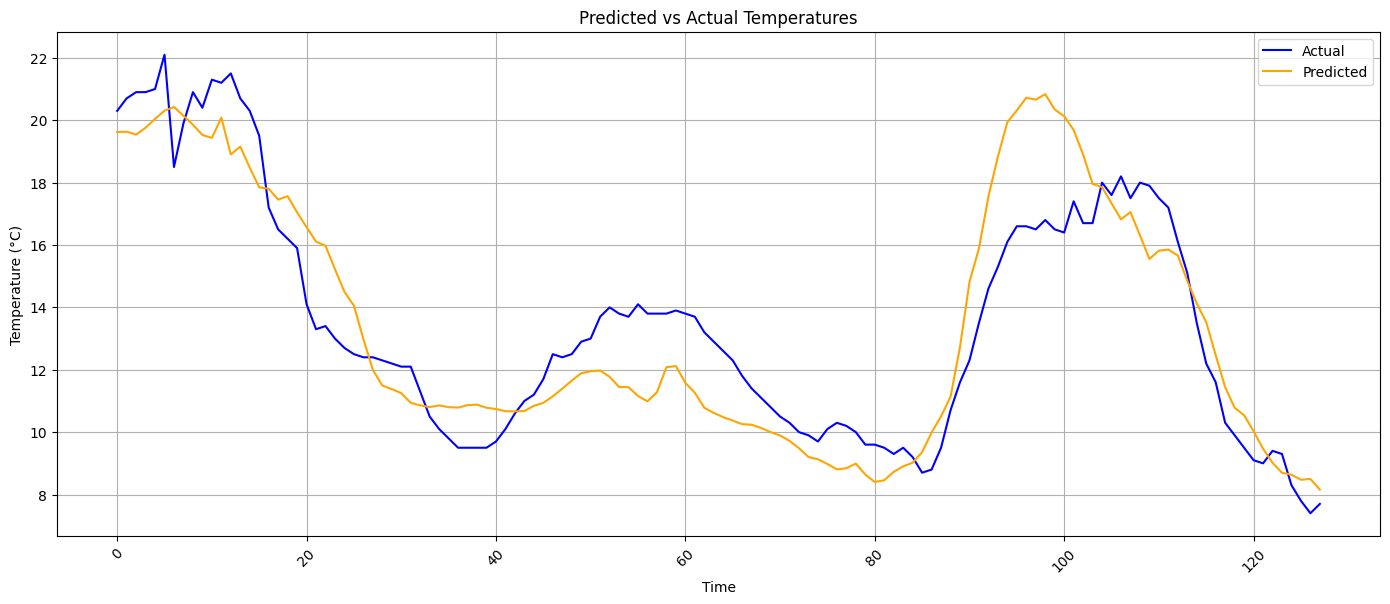

In [ ]:
""" plt.figure(figsize=(14, 6))
plt.plot(actuals_rescaled, label="Actual", color="blue")
plt.plot(predictions_rescaled, label="Predicted", color="orange")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Predicted vs Actual Temperatures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show() """

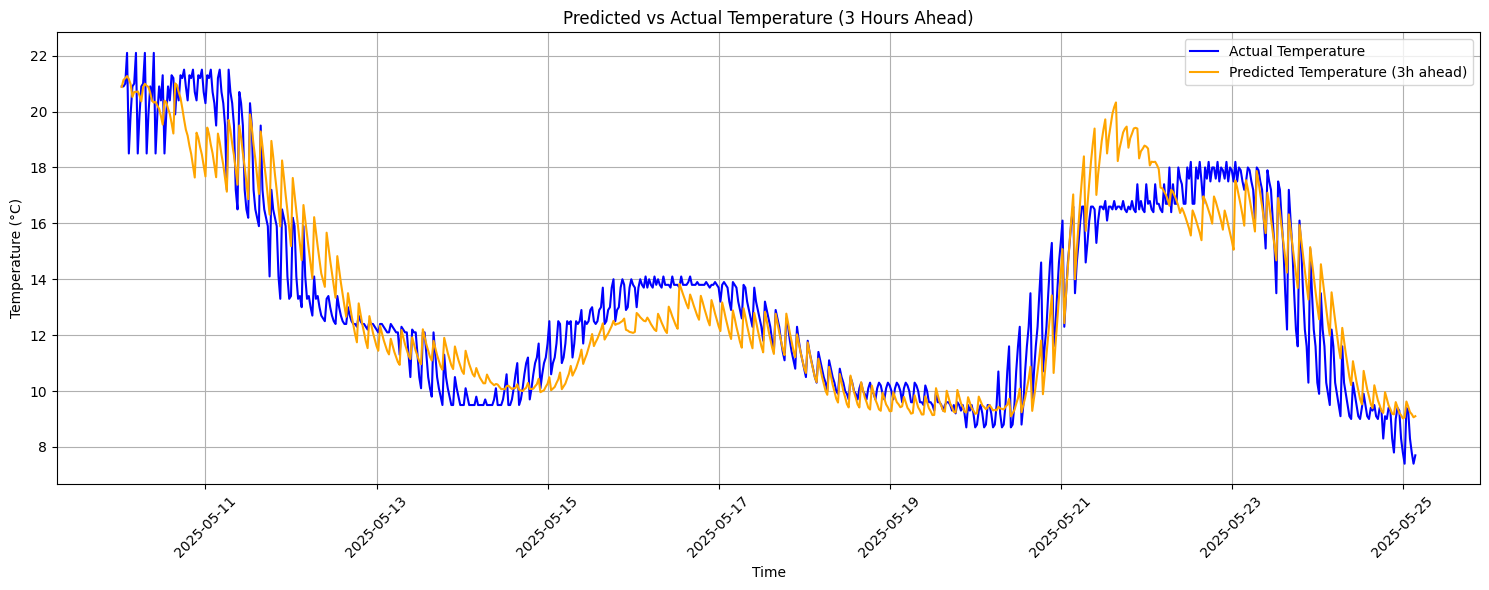

In [ ]:
""" test_start_idx = len(df) - len(actuals_rescaled)
prediction_start_idx = test_start_idx + forecast_horizon

# Slice predictions and actuals to match
predictions_rescaled_aligned = predictions_rescaled[:-forecast_horizon]
actuals_rescaled_aligned = actuals_rescaled[forecast_horizon:]

# Make sure lengths match
assert len(predictions_rescaled_aligned) == len(actuals_rescaled_aligned)

# Extract the corresponding time values
aligned_time = df["Date"].iloc[prediction_start_idx : prediction_start_idx + len(predictions_rescaled_aligned)]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(aligned_time, actuals_rescaled_aligned, label="Actual Temperature", color='blue')
plt.plot(aligned_time, predictions_rescaled_aligned, label="Predicted Temperature (3h ahead)", color='orange')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Predicted vs Actual Temperature (3 Hours Ahead)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show() """

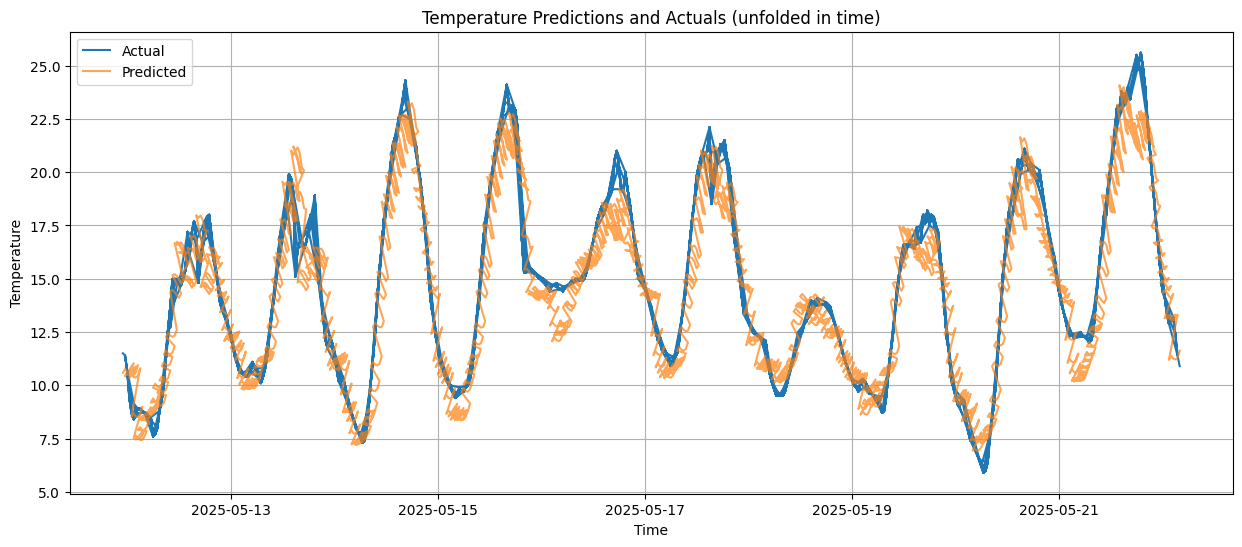

In [ ]:
predictions_2d = predictions.reshape(-1, 1)
actuals_2d = actuals.reshape(-1, 1)

n_samples, forecast_horizon = predictions.shape

# Apply inverse transform
predictions_rescaled = temp_scaler.inverse_transform(predictions_2d).reshape(n_samples, forecast_horizon)
actuals_rescaled = temp_scaler.inverse_transform(actuals_2d).reshape(n_samples, forecast_horizon)

forecast_horizon = 6
time_step_minutes = 30  # since 6 steps correspond to 3 hours (6 * 30 mins)

# Create a continuous time axis for all predictions by expanding each start date + horizon steps
all_times = []
all_preds = []
all_actuals = []

# total samples in your dataset (X.shape[0])
total_samples = len(df) - lookback - forecast_horizon + 1
# all start dates for samples
all_start_dates = df['Date'].iloc[:total_samples].reset_index(drop=True)
# get test start dates
test_dates = all_start_dates.iloc[-len(X_test):].reset_index(drop=True)

for i, start_time in enumerate(test_dates):
    for step in range(forecast_horizon):
        all_times.append(start_time + pd.Timedelta(minutes=time_step_minutes * (step + 1)))
        all_preds.append(predictions_rescaled[i, step])
        all_actuals.append(actuals_rescaled[i, step])

all_times = pd.to_datetime(all_times)
all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

plt.figure(figsize=(15, 6))
plt.plot(all_times, all_actuals, label='Actual')
plt.plot(all_times, all_preds, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Predictions and Actuals (unfolded in time)')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(all_actuals, all_preds)
mae = mean_absolute_error(all_actuals, all_preds)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 2.3340, MAE: 1.1857


In [29]:
print(len(all_actuals))
print(len(all_preds))
print(all_actuals[-18:-12])
print(predictions_rescaled[-3])

2910
2910
[14.2      13.4      12.9      13.099999 13.2      12.4     ]
[13.139373 13.296916 13.171394 13.076271 13.057064 13.313554]


Finetuning Hyperparameters

In [35]:
def objective(trial):

    # Suggest hyperparameters to try
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Create your dataset and dataloaders with suggested batch_size
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model with suggested parameters
    input_size = X_train.shape[2]
    model = TemperatureForecaster(input_size=input_size,
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 dropout=dropout,
                                 forecast_horizon=6)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 30  # You can keep epochs small for tuning
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        val_loss /= len(val_loader.dataset)
        
        # You can report intermediate results to Optuna (optional)
        trial.report(val_loss, epoch)
        
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


In [43]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(next(model.parameters()).device)

None
False
cpu


In [46]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # number of hyperparameter trials to run

print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

[I 2025-05-27 17:36:13,156] A new study created in memory with name: no-name-78d376a0-2984-421f-bf70-eac2464e1a3d
C:\Users\jakob\AppData\Local\Temp\ipykernel_29540\3192769052.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
c:\Users\jakob\AppData\Local\pypoetry\Cache\virtualenvs\iis-temperature-forecaster--Ib5HjuI-py3.11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.44122404542733984 and num_layers=1
  warnings.warn(
[I 2025-05-27 17:42:03,752] Trial 0 finished with value: 0.005156933189580966 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.44122404542733984, 'lr': 0.0011085166470718914, 'batch_size': 64}. Best

Best hyperparameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.12268523469728418, 'lr': 0.009692036129087386, 'batch_size': 32}
Best validation loss: 0.0038999151327460046
